In [25]:
#Importing the necessary packages 
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from itertools import chain
from nltk.util import ngrams
from sklearn.preprocessing import LabelEncoder

Dataset Source lInk: https://www.kaggle.com/datasets/chaudharyanshul/airline-reviews
### MetaData
##### Columns:
    OverallRating:    The overall rating given by the customer.
    ReviewHeader:     The header or title of the customer's review.
    Name:             The name of the customer providing the feedback.
    Datetime:         The date and time when the feedback was posted.
    VerifiedReview:   Indicates whether the review is verified or not.
    ReviewBody:       The detailed body of the customer's review.
    TypeOfTraveller:  The type of traveler (e.g., Business, Leisure).
    SeatType:         Class of the traveler (e.g. Business, Economy).
    Route:            The flight route taken by the customer.
    DateFlown:        The date when the flight was taken.
    SeatComfort:      Rating for seat comfort.
    CabinStaffService: Rating for cabin staff service.
    GroundService:      Rating for ground service.
    ValueForMoney:      Rating for the value for money.
    Recommended:        Whether the customer recommends British Airways.
    Aircraft:           The aircraft used for the flight.
    Food&Beverages:      Rating for food and beverages.
    InflightEntertainment: Rating for inflight entertainment.
    Wifi&Connectivity:    Rating for onboard wifi and connectivity.

In [27]:

british_airways = pd.read_csv('./Data/BA_AirlineReviews.csv')

In [28]:
#Renaming column

british_airways.rename({"Unnamed: 0":"ReviewID"},axis=1,inplace=True)

In [29]:
british_airways.head(5)

,ReviewID,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0


In [30]:
#Sentiment analysis
# columns: "ReviewHeader","ReviewBody"

#Initializing the model and defining function to pass 
# Ovreall ReviewHeader Analysis
Analyzer = SentimentIntensityAnalyzer()
func = lambda x: Analyzer.polarity_scores(x)
# Applying the model to the review header text and extracting the compound sentiment rating
header_polarity = british_airways["ReviewHeader"].apply(func)
british_airways["Header_Overall_Sentiment"] = header_polarity.apply(lambda x: x['compound'] )

## Applying the model to the review body text and extracting the compound sentiment rating
body_polarity = british_airways["ReviewBody"].apply(func)
british_airways["Body_Overall_Sentiment"] = body_polarity.apply(lambda x: x['compound'] )

In [31]:
def sentiment_keywords_with_id(text, review_id, n=2):
    stop_words = set(stopwords.words('english'))
    tokenize_column = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    extracted_words = [word for word in tokenize_column if word.isalpha() and word not in stop_words]

    # Generate n-grams (bigrams, trigrams, etc.)
    n_grams = list(ngrams(extracted_words, n))  # Extract n-grams

    # Analyze the sentiment of each n-gram
    positive_phrases = []
    negative_phrases = []
    neutral_phrases = []
    
    for phrase in n_grams:
        phrase_str = ' '.join(phrase)  # Convert n-gram tuple to a string
        phrase_score = Analyzer.polarity_scores(phrase_str)  # Get sentiment scores for the phrase
        
        if phrase_score['compound'] >= 0.4:
            positive_phrases.append(phrase_str)
        elif phrase_score['compound'] <= -0.4:
            negative_phrases.append(phrase_str)
        elif -0.2 <= phrase_score['compound'] <= 0.2:
            neutral_phrases.append(phrase_str)
    
    return {
        'positive_phrases': positive_phrases,
        'neutral_phrases': neutral_phrases,
        'negative_phrases': negative_phrases
    }

# Apply the sentiment analysis function with ReviewID
british_airways['keyw'] = british_airways.apply(lambda row: sentiment_keywords_with_id(row['ReviewBody'], row.name), axis=1)

# Extract individual phrase columns
british_airways["positive_phrases"] = british_airways["keyw"].apply(lambda x: x.get('positive_phrases', []))
british_airways["neutral_phrases"] = british_airways["keyw"].apply(lambda x: x.get('neutral_phrases', []))
british_airways["negative_phrases"] = british_airways["keyw"].apply(lambda x: x.get('negative_phrases', []))
def tract_phrase_count(ReviewID, Phrases_Col):
    # Map Phrases with their respective ReviewIDs
    mapped_data = []  # initialization
    for review_id, phrases in zip(ReviewID, Phrases_Col):
        # Make `phrases' iterable (list of phrases)
        if isinstance(phrases, list):
            for phrase in phrases:
                mapped_data.append((review_id, phrase))
    
    # Convert to a DataFrame
    dataframe = pd.DataFrame(mapped_data, columns=['ReviewID', 'Phrases'])
    
    # Count occurrences of each phrase per ReviewID
    phrase_count = dataframe.groupby(['ReviewID', 'Phrases']).size().reset_index(name='Phrase_Count')
    
    return phrase_count


# Call the function
PositivePhraseCountPerReview = tract_phrase_count(british_airways["ReviewID"], british_airways["positive_phrases"]).sort_values(by= 'Phrase_Count',ascending=False)
NeutralPhraseCountPerReview = tract_phrase_count(british_airways["ReviewID"], british_airways["neutral_phrases"]).sort_values(by= 'Phrase_Count',ascending=False)
NegativePhraseCountPerReview = tract_phrase_count(british_airways["ReviewID"], british_airways["negative_phrases"]).sort_values(by= 'Phrase_Count',ascending=False)


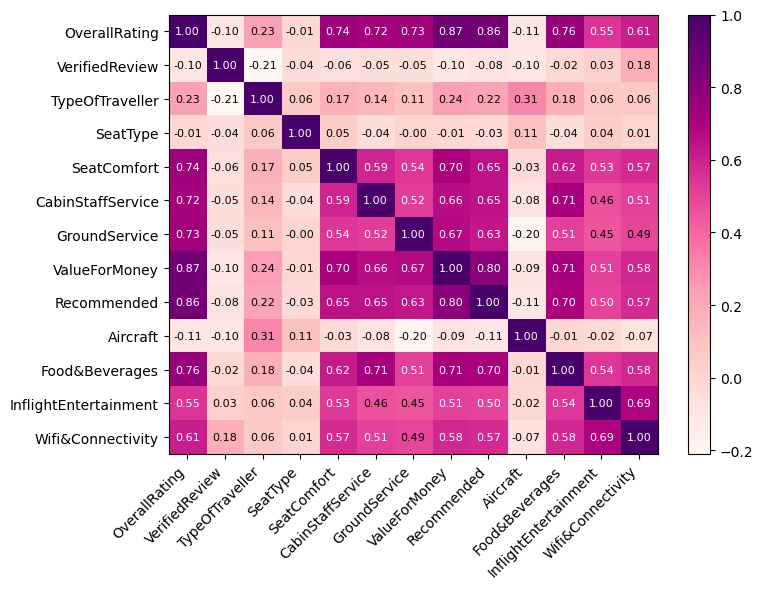

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Create a copy of the DataFrame
british_airways_copy = british_airways.copy()            #--Change to dataset.copy() in POWER BI

# List of columns to include in the analysis
columns = ['OverallRating', 'VerifiedReview', 'TypeOfTraveller', 'SeatType',
           'SeatComfort', 'CabinStaffService', 'GroundService', 'ValueForMoney', 
           'Recommended', 'Aircraft', 'Food&Beverages', 'InflightEntertainment', 'Wifi&Connectivity']

categorical_columns = ['TypeOfTraveller', 'SeatType', 'Recommended', 'Aircraft']

# Keep only the relevant columns
british_airways_copy = british_airways_copy[columns]

# Encode categorical columns
for col in categorical_columns:
    le_model = LabelEncoder()
    british_airways_copy[col] = le_model.fit_transform(british_airways_copy[col].astype(str))

# Compute the correlation matrix
correlation_matrix = british_airways_copy.corr()
correlation_matrix = correlation_matrix.round(2)

# Visualize the table
plt.figure(figsize=(8, 6), facecolor='none')

# Create the heatmap
plt.imshow(correlation_matrix, cmap='RdPu', interpolation='none', aspect='auto')
plt.colorbar()

# Add correlation values to the heatmap
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                 ha='center', va='center', color='black' if abs(correlation_matrix.iloc[i, j]) < 0.5 else 'white',
                 fontsize=8)

# Configure the ticks and labels
plt.xticks(ticks=np.arange(len(correlation_matrix.columns)), labels=correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(correlation_matrix.index)), labels=correlation_matrix.index)
plt.tight_layout()
plt.show()

In [33]:
#Save the datafranes into excel for power bi visualization

british_airways.to_csv('./Data/british_airways_fact.csv',index=False)
PositivePhraseCountPerReview.to_csv('./Data/Dim_PositivePhraseCountPerReview.csv',index=False)
NeutralPhraseCountPerReview.to_csv('./Data/Dim_Neutral_Phrase_Count_Per_Review.csv',index=False)
NegativePhraseCountPerReview.to_csv('./Data/Dim_Negative_Phrase_Count_Per_Review.csv',index=False)

In [34]:
british_airways.head()

,ReviewID,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,...,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity,Header_Overall_Sentiment,Body_Overall_Sentiment,keyw,positive_phrases,neutral_phrases,negative_phrases
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,...,NaN,NaN,NaN,NaN,-0.4767,-0.9342,"{'positive_phrases': ['check hand', 'hand lugg...","[check hand, hand luggage, travel hand, hand l...","[hours takeoff, takeoff received, received mai...","[delay forced, forced check, due incompetent, ..."
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,...,A320,1.0,2.0,2.0,0.0000,-0.9209,"{'positive_phrases': ['immediately hopes', 'ho...","[immediately hopes, hopes clearing, drink ente...","[british airways, airways bru, bru lhr, lhr du...","[old dirty, dirty power, unhelpful error, erro..."
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,...,A320,4.0,NaN,NaN,0.0000,0.5927,"{'positive_phrases': ['drinks good', 'good sho...","[drinks good, good short]","[boarded time, time took, took ages, ages get,...",[]
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,...,NaN,NaN,NaN,NaN,-0.5095,-0.8489,"{'positive_phrases': ['thinking pretty', 'pret...","[thinking pretty, pretty easy, easy get]","[days flight, flight advised, advised ba, aske...","[absolutely hopeless, hopeless airline, even w..."
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,...,NaN,1.0,1.0,1.0,0.0000,0.8392,"{'positive_phrases': ['spain friends', 'friend...","[spain friends, friends ever, tell friends, fr...","[traveled lisbon, vacation cruise, cruise port...",[]


In [35]:
PositivePhraseCountPerReview.head()

,ReviewID,Phrases,Phrase_Count
265,47,help us,6
22614,3091,entertainment system,4
6510,1081,customer care,3
1226,246,inflight entertainment,3
2113,402,arrived nice,3
